In [1]:
#!pip install git+https://github.com/microsoft/dowhy.git

In [1]:
import numpy as np
import pandas as pd
import dowhy
from dowhy import CausalModel
import networkx as nx

/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/networkx/utils/backends.py:135: RuntimeWarning: networkx backend defined more than once: nx-loopback
  backends.update(_get_backends("networkx.backends"))


In [2]:
df = pd.read_csv("bpi2017_filledLog.csv")

In [3]:
df['treatment'] = df['treatment'].replace({'treated': 1, 'notTreated': 0})

In [4]:
treatment=df['treatment']
features = df[['FirstWithdrawalAmount', 'NumberOfTerms', 'MonthlyCost', 'CreditScore', 'OfferedAmount']]
y=df['successful']

In [5]:
dot_graph = nx.DiGraph ([('treatment', 'successful'), ('OfferedAmount', 'successful'), ('FirstWithdrawalAmount','successful'), ('NumberOfTerms', 'successful'), ('MonthlyCost', 'successful'), ('CreditScore', 'MonthlyCost'), ('CreditScore', 'NumberOfTerms'), ('CreditScore', 'OfferedAmount'),  ('CreditScore', 'FirstWithdrawalAmount')])

In [6]:
#ml_graph = dowhy.graph[directed 1node[ id "successful" label "y"]node[ id "CreditScore" label "CS"] node[ id "OfferedAmount" label "OA"] node[ id "NumberOfTerms" label "NT"] node[ id "MonthlyCost" label "MC"] node[ id "treatment" label "T"] edge[source "T" target "y"]edge[ source "CS" target "T"] edge[ source "OA" target "y"] edge[ source "NT" target "y"] edge[ source "MC" target "y"]]

In [6]:
model1 = CausalModel(
   data=df, # some pandas dataframe
   treatment='treatment',
   outcome='successful',
   graph="\n".join(nx.generate_gml(dot_graph))
)

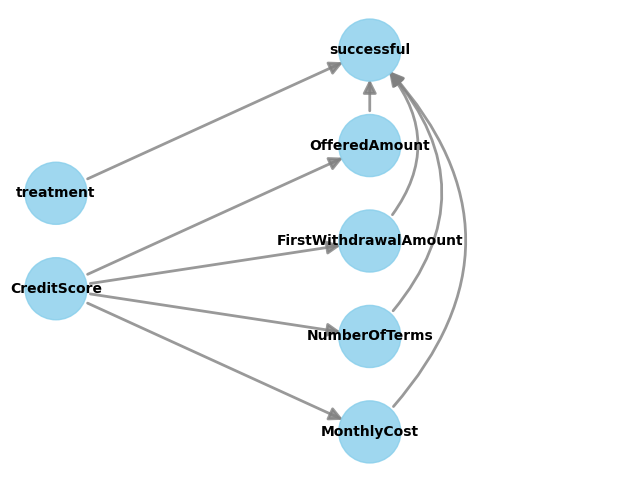

In [7]:
model1.view_model()

In [8]:
identified_estimand= model1.identify_effect(proceed_when_unidentifiable=True)
print(identified_estimand)

Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[successful])
d[treatment]               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,,U) = P(successful|treatment,)

### Estimand : 2
Estimand name: iv
No such variable(s) found!

### Estimand : 3
Estimand name: frontdoor
No such variable(s) found!



In [9]:
# Run a linear regression of column successful on treatment in df
import statsmodels.api as sm

X = df['treatment'].astype(int)
y = df['successful'].astype(int)

X = sm.add_constant(X)

ols = sm.OLS(y, X).fit()

# Display a more parsimonious results summary
print(ols.summary().tables[1])

                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.6287      0.001   1181.877      0.000       0.628       0.630
treatment      0.0646      0.001     70.024      0.000       0.063       0.066


/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]
/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[successful])
d[treatment]               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,,U) = P(successful|treatment,)

## Realized estimand
b: successful~treatment+treatment*MonthlyCost+treatment*OfferedAmount+treatment*NumberOfTerms+treatment*FirstWithdrawalAmount+treatment*CreditScore
Target units: ate

## Estimate
Mean value: 0.12556657386894043

Refute: Add a random common cause
Estimated effect:0.12556657386894043
New effect:0.12556668471136503
p value:0.8799999999999999



/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


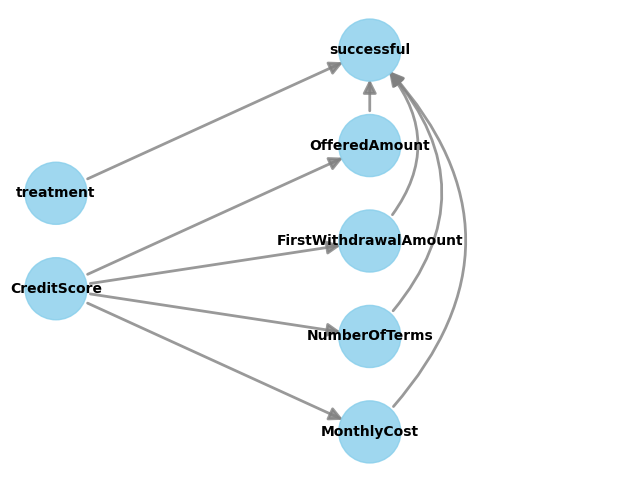

In [10]:
# Step 2: Identify the causal effect
identified_estimand = model1.identify_effect()

# Step 3: Estimate the causal effect
estimate = model1.estimate_effect(identified_estimand, method_name="backdoor.linear_regression")

# Step 4: Refute the estimate
refute_results = model1.refute_estimate(identified_estimand, estimate, method_name="random_common_cause")

# Step 5: Print results
print(estimate)
print(refute_results)

# Step 6: Plot the causal graph
graph = model1.view_model()
#graph.save_graph("causal_graph.gml")

In [11]:
linear_estimate = model1.estimate_effect(identified_estimand,
                                        method_name="backdoor.linear_regression",
                                       control_value=0,
                                       treatment_value=1)
print(linear_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[successful])
d[treatment]               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,,U) = P(successful|treatment,)

## Realized estimand
b: successful~treatment+treatment*MonthlyCost+treatment*OfferedAmount+treatment*NumberOfTerms+treatment*FirstWithdrawalAmount+treatment*CreditScore
Target units: ate

## Estimate
Mean value: 0.12556657386894043



/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/dowhy/causal_estimators/regression_estimator.py:128: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  intercept_parameter = self.model.params[0]


In [13]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LassoCV
from sklearn.ensemble import GradientBoostingRegressor
simple_dml_estimate = model1.estimate_effect(identified_estimand, method_name="backdoor.econml.dml.DML",
                                     control_value = 0,
                                     treatment_value = 1,
                                 target_units = 1,  # condition used for CATE
                                 confidence_intervals=False,
                                method_params={"init_params":{'model_y':GradientBoostingRegressor(),
                                                              'model_t': GradientBoostingRegressor(),
                                                              "model_final":LassoCV(fit_intercept=False),
                                                              'featurizer':PolynomialFeatures(degree=1, include_bias=True)},
                                               "fit_params":{}})
print(simple_dml_estimate)

/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
/home/ma/ma_ma/ma_mskiera/.local/lib/python3.9/site-packages/shap/utils/_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimizatio

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[successful])
d[treatment]               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,,U) = P(successful|treatment,)

## Realized estimand
b: successful~treatment | MonthlyCost,OfferedAmount,NumberOfTerms,FirstWithdrawalAmount,CreditScore
Target units: 

## Estimate
Mean value: 0.1250847012491106
Effect estimates: [[0.15104658]
 [0.15104658]
 [0.15104658]
 ...
 [0.19897613]
 [0.19897613]
 [0.19897613]]



In [15]:
print(simple_dml_estimate)

*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
     d                     
────────────(E[successful])
d[treatment]               
Estimand assumption 1, Unconfoundedness: If U→{treatment} and U→successful then P(successful|treatment,,U) = P(successful|treatment,)

## Realized estimand
b: successful~treatment | MonthlyCost,OfferedAmount,NumberOfTerms,FirstWithdrawalAmount,CreditScore
Target units: 

## Estimate
Mean value: 0.1250847012491106
Effect estimates: [[0.15104658]
 [0.15104658]
 [0.15104658]
 ...
 [0.19897613]
 [0.19897613]
 [0.19897613]]



In [16]:
#does not seem to work or at least does not give a value after 30+ minutes
res_random=model1.refute_estimate(identified_estimand, simple_dml_estimate, method_name="random_common_cause")
print(res_random)

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
is_sparse is deprecated and will be removed in a future version. Check `

KeyboardInterrupt: 

In [ ]:
# IV. Refute the obtained estimate using multiple robustness checks.
res_placebo=model.refute_estimate(identified_estimand, simple_dml_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

In [18]:
res_random=model1.refute_estimate(identified_estimand, linear_estimate, method_name="random_common_cause")
print(res_random)
res_placebo=model1.refute_estimate(identified_estimand, linear_estimate,
        method_name="placebo_treatment_refuter", placebo_type="permute",
        num_simulations=20)
print(res_placebo)

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Refute: Add a random common cause
Estimated effect:0.12556657386894043
New effect:0.1255666814810254
p value:1.0



Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (con

Refute: Use a Placebo Treatment
Estimated effect:0.12556657386894043
New effect:0.00013186381198140306
p value:0.41058629645652434



Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`


In [24]:
# III. Estimate the target estimand using a statistical method.
propensity_strat_estimate = model1.estimate_effect(identified_estimand,
                                 method_name="backdoor.dowhy.propensity_score_stratification")

print(propensity_strat_estimate)

Exception: No common causes/confounders present. Propensity score based methods are not applicable